# Goal of this notebook #

Using the Gaussian mixture model for probabilistic clustering.

## Some introduction ##

The probabilistic clustering can be done by calculating the likelihood of each data point as

$$ P(x_i|\theta) = \sum_{k=1}^{N_{\rm class}}P(x_i,t=k|\theta_k) \pi(t=k) $$

where $\theta_k$ is the parameter for the $k$th class and $\pi(t=k)$ is the prior.

If $P(x_i,t=k|\theta_k)$ is Gaussian, then

$$ P(x_i,t=k|\theta_k) = {\mathcal N}(x_i|\mu_i,\Sigma_i) $$

where $\mu_i$ is an $n$-d vector parametrizing the mean of the distribution and $\Sigma_i$ is an $n\times n$ matrix parametrizing the covariance of the distribution.

We shall demonstrate that using the probabilistic clustering, we can estimate $\mu_i$ and $\Sigma_i$ for all classes.

In [1]:
# load the required packages
import numpy as np
import numpy.random as npr
from scipy.stats import multivariate_normal
import matplotlib.pyplot as pt
%matplotlib inline
import time
from IPython import display

We first define the function that generates the data.

For simplicity, We set the data to follow the multivariate Gaussian distribution in 2-d space.

Therefore, the inputs of the function are the number of data, the two vectors with 2 components for the mean ($\mu_1$ and $\mu_2$), and the two $2\times2$ matrices for the covariance ($\Sigma_1$ and $\Sigma_2$). We also set the random seeds so that the results are reproducable.

In [2]:
def generate_data(n_data,mu1,mu2,cov1,cov2,seed1=24,seed2=42):
    data1_true = multivariate_normal.rvs(mean=mu1_true,cov=cov1_true,size=n_data, random_state=24)
    data2_true = multivariate_normal.rvs(mean=mu2_true,cov=cov2_true,size=n_data, random_state=42)
    data = np.concatenate((data1_true,data2_true))

    return data1_true,data2_true,data

Let us now generate some random mean vectors and covariances.

Since the covariance needs to have positive definite, we start by generating a non-negative variance vector with 2 components. We then generate the correlation matrix with the diagonal elements set to be unity and the off-diagonal elements set to be uniform random number between -1 and 1. We also make sure that the correlation matrix is symmetric.

Once we generate data, we visualize them. The left panel displays the scatter plot of the true classes (red square and blue triangle) in 2-d space. The right panel displays the data point without classes, and this is the data that we will be working with.

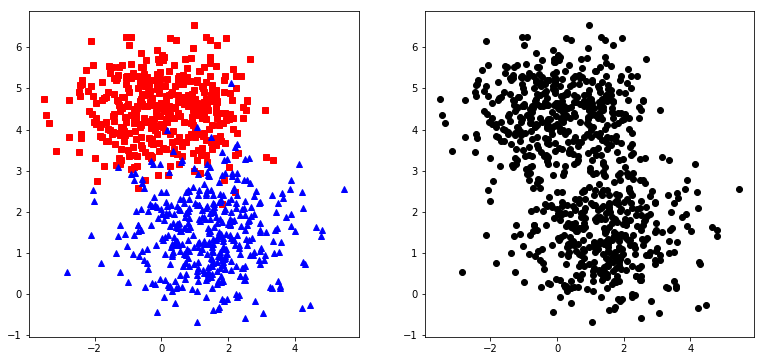

In [3]:
npr.seed(48)

mu1_true = npr.rand(2)*5
mu2_true = npr.rand(2)*5

var1_true = npr.rand(2)*2
var2_true = npr.rand(2)*2

corr1_true = np.array([[1,0],[0,1]])
corr2_true = np.array([[1,0],[0,1]])
corr1_true[0,1] = corr1_true[1,0] = 2*np.random.rand(1)-1
corr2_true[0,1] = corr2_true[1,0] = 2*np.random.rand(1)-1

cov1_true = corr1_true*np.sqrt(np.outer(var1_true,var1_true))
cov2_true = corr2_true*np.sqrt(np.outer(var2_true,var2_true))

data1_true,data2_true,data = generate_data(400,mu1_true,mu2_true,cov1_true,cov2_true)

pt.figure(1,figsize=(13,6))
pt.subplot(1,2,1)
pt.plot(data1_true[:,0],data1_true[:,1],'rs')
pt.plot(data2_true[:,0],data2_true[:,1],'b^')
pt.subplot(1,2,2)
pt.plot(data[:,0],data[:,1],'ko')
pt.show()

# compute the logarithmic of the total probablility P(x|theta) [including prior] using the true parameters
prob1_true = multivariate_normal.pdf(data,mean=mu1_true,cov=cov1_true)
prob2_true = multivariate_normal.pdf(data,mean=mu2_true,cov=cov2_true)
prob_true = 0.5*prob1_true+0.5*prob2_true
lnprob_true = np.sum(np.log(prob_true))

Since we want to visualize the logarithmic of the probability density function, we create meshes for $(x,y)$ between -4 and 8 with step size 0.5. We then compute the two logarithmic of the probability density functions using the true parameters (which are named as parameter_true).

In [4]:
# create 1-d x_plot and y_plot
x_plot = np.arange(-4,8,0.5)
y_plot = np.arange(-4,8,0.5)

# create the xy meshes from x_plot and y_plot
xx_plot, yy_plot = np.meshgrid(x_plot,y_plot)
xy_plot = np.stack((xx_plot,yy_plot),axis=-1)

# compute the logarithmic probabilities of the two Gaussian pdfs
# using the true parameters on xy meshes for visualization
lnprob1_true_plot = multivariate_normal.logpdf(xy_plot,mean=mu1_true,cov=cov1_true)
lnprob2_true_plot = multivariate_normal.logpdf(xy_plot,mean=mu2_true,cov=cov2_true)

The algorithm of expectation maximization (EM) works as follows:
1. We start with some initialization of $\mu_k$ and $\Sigma_k$ (named as parameter_new).
2. Using these $\mu_k$ and $\Sigma_k$, we compute the probablilities of the data point for all classes using the corresponding Gaussian PDF.
3. We then assign $x_i$ to class $k$ if ${\mathcal N}(x_i|\mu_k,\Sigma_k)$ is the largest among all classes.
4. We re-estimate $\mu_k$ and $\Sigma_k$ using the data point with the updated classes.
5. If the difference between last two estimates is smaller than some threshold, we stop; otherwise, we repeat the process from step 1.

The algorithm is implemented in the function "expectation_maximization". In the function we also visualize the current estimated classes and PDFs in the left panel, whereas the right panel shows the truth for comparison.

In [5]:
def expectation_maximization(mu1_new,mu2_new,cov1_new,cov2_new,diff_thres=1e-5):

    # parameter_old stores the estimated parameters from the previous step
    # parameter_old are initialized to be zero so the total difference is greater than the threshold
    mu1_old = np.array([0,0])
    mu2_old = np.array([0,0])
    cov1_old = np.array([[0,0],[0,0]])
    cov2_old = np.array([[0,0],[0,0]])
    
    # the difference between the latest two estimates is computed as the sum of mu_k and cov_k difference
    # (this choice is rather trivial but serves for our purpose)
    total_diff = (np.sum(np.abs(mu1_new-mu1_old))
                 +np.sum(np.abs(mu2_new-mu2_old))
                 +np.sum(np.abs(cov1_new-cov1_old))
                 +np.sum(np.abs(cov2_new-cov2_old)))

    # count the number of iterations for the EM algorithm
    n_iteration = 0

    # loop until the total difference is smaller than the threshold
    while total_diff>diff_thres:

        # update parameter_old with the latest estimate
        mu1_old = mu1_new+0
        mu2_old = mu2_new+0
        cov1_old = cov1_new+0
        cov2_old = cov2_new+0

        # compute the probabilities of all data points for the two Gaussian distributions
        # (note that we do not include the prior since n_data1=n_data2, implying uniform prior)
        prob1 = multivariate_normal.pdf(data,mean=mu1_old,cov=cov1_old)
        prob2 = multivariate_normal.pdf(data,mean=mu2_old,cov=cov2_old)

        # assign the data ponits to be class 1 if prob1>=prob2, and the rest to be class 2
        condition_data1 = prob1>=prob2
        data1 = data[condition_data1,:]
        data2 = data[~condition_data1,:]

        # re-estimate the parameters using the newly assigned classes
        # results are stored in parameter_new
        mu1_new = np.mean(data1,axis=0)
        mu2_new = np.mean(data2,axis=0)
        cov1_new = np.cov(data1.T,ddof=1)
        cov2_new = np.cov(data2.T,ddof=1)

        # compute the difference between the latest two estimates
        total_diff = (np.sum(np.abs(mu1_new-mu1_old))
                     +np.sum(np.abs(mu2_new-mu2_old))
                     +np.sum(np.abs(cov1_new-cov1_old))
                     +np.sum(np.abs(cov2_new-cov2_old)))
        
        # add 1 to n_iteration
        n_iteration = n_iteration+1

        # compute the logarithmic probabilities of the two Gaussian pdfs
        # using the estimated parameters on meshes for visualization
        lnprob1_plot = multivariate_normal.logpdf(xy_plot,mean=mu1_old,cov=cov1_old)
        lnprob2_plot = multivariate_normal.logpdf(xy_plot,mean=mu2_old,cov=cov2_old)

        # compute the logarithmic of the total probablility P(x|theta) including prior using the estimated parameters
        prob1 = multivariate_normal.pdf(data,mean=mu1_old,cov=cov1_old)
        prob2 = multivariate_normal.pdf(data,mean=mu2_old,cov=cov2_old)
        prob = 0.5*prob1+0.5*prob2
        lnprob = np.sum(np.log(prob))

        pt.figure(1,figsize=(13,6))
        pt.clf()

        # plot for the estimate for this iteration
        pt.subplot(1,2,1)
        pt.title('iteration %d: sum of log probability = %.5e'%(n_iteration,lnprob))
        pt.contourf(x_plot,y_plot,lnprob1_plot,cmap='Reds',levels=5,alpha=1)
        pt.contourf(x_plot,y_plot,lnprob2_plot,cmap='Blues',levels=5,alpha=0.6)
        pt.plot(data1[:,0],data1[:,1],'rs',alpha=0.6)
        pt.plot(data2[:,0],data2[:,1],'b^',alpha=0.6)

        # plot for the true for comparison
        pt.subplot(1,2,2)
        pt.title('truth: sum of log probability = %.5e'%(lnprob_true))
        pt.contourf(x_plot,y_plot,lnprob1_true_plot,cmap='Reds',levels=5,alpha=1)
        pt.contourf(x_plot,y_plot,lnprob2_true_plot,cmap='Blues',levels=5,alpha=0.6)
        pt.plot(data1_true[:,0],data1_true[:,1],'rs',alpha=0.6)
        pt.plot(data2_true[:,0],data2_true[:,1],'b^',alpha=0.6)
    
        display.display(pt.gcf())
        display.clear_output(wait=True)
        
        time.sleep(0.2)

    return n_iteration,condition_data1,mu1_old,mu2_old,cov1_old,cov2_old,lnprob

Let us now perform the EM algorithm with some random initialization on the parameters.

Again, we make sure that the variances are greater than zero and the off-diagonal elements of the correlation matrices are between -1 and 1.

After 8 iterations, that the EM algorithm converges. Comparing the two panels, we find that the EM algorithm works reasonably well - the estimated parameters are close, the classification is quite accurate except some points in the middle (the order reverses but this is irrelevant), and the sum of the logarithmic total probability are very close.

difference between mu1 and mu2:  [-0.0606056  -0.01545144] [ 0.0336678  -0.07491122]
difference between cov1:  [0.03027597 0.04908035] [ 0.04908035 -0.03472131]
difference between cov2:  [-0.10569291  0.07421477] [ 0.07421477 -0.18408223]


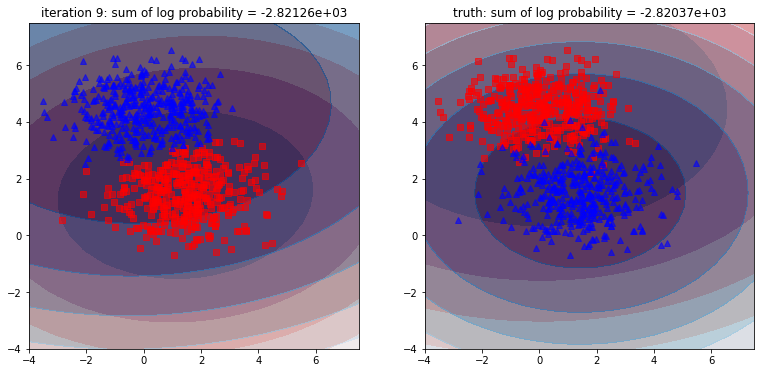

In [6]:
npr.seed(84)

mu1_new = npr.rand(2)*5
mu2_new = npr.rand(2)*5

var1_new = npr.rand(2)*2
var2_new = npr.rand(2)*2

corr1_new = np.array([[1,0],[0,1]])
corr2_new = np.array([[1,0],[0,1]])
corr1_new[0,1] = corr1_new[1,0] = 2*np.random.rand(1)-1
corr2_new[0,1] = corr2_new[1,0] = 2*np.random.rand(1)-1

cov1_new = corr1_new*np.sqrt(np.outer(var1_new,var1_new))
cov2_new = corr2_new*np.sqrt(np.outer(var2_new,var2_new))

n_iteration,condition_data1,mu1_new,mu2_new,cov1_new,cov2_new,lnprob = expectation_maximization(mu1_new,mu2_new,cov1_new,cov2_new)

# the order reverses so we take the differences between parameter(i)_new and parameter(j)_true
print('difference between mu1 and mu2: ',mu2_new-mu1_true,mu1_new-mu2_true)
print('difference between cov1: ',cov2_new[:,0]-cov1_true[:,0],cov2_new[:,1]-cov1_true[:,1])
print('difference between cov2: ',cov1_new[:,0]-cov2_true[:,0],cov1_new[:,1]-cov2_true[:,1])

One problem of the EM algorithm is that it can be sensitive to local maximums.

If we inentionally initialize the parameters such that the classification is somewhat diagomal compared to the true, then after 17 iterations we find that the algorithm will converge to a local maximums - the logarithimic total probability is significantly smaller than the truth!

Therefore, to utilize the EM algorithm for probabilistic clustering, we must run multiple random initializations, and choose the ones with the largest logarithimic total probability. This cannot guarantee that we reach the global maximum, but at least we are closer to the truth...

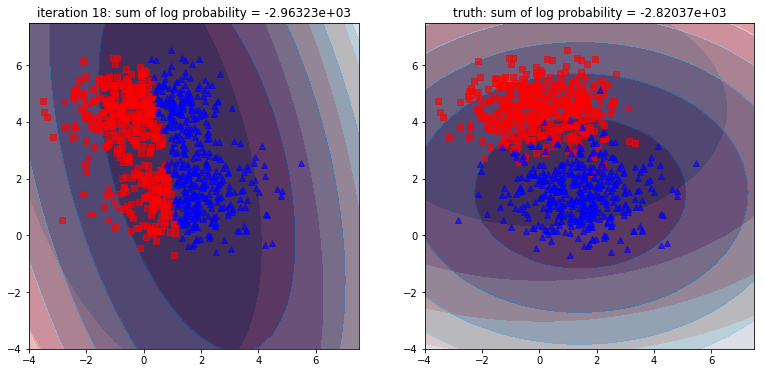

In [7]:
mu1_new = np.array([-2,2])
mu2_new = np.array([4,4])

var1_new = np.array([1,1])
var2_new = np.array([1,1])

corr1_new = np.array([[1,0],[0,1]])
corr2_new = np.array([[1,0],[0,1]])

cov1_new = corr1_new*np.sqrt(np.outer(var1_new,var1_new))
cov2_new = corr2_new*np.sqrt(np.outer(var2_new,var2_new))

n_iteration,condition_data1,mu1_new,mu2_new,cov1_new,cov2_new,lnprob = expectation_maximization(mu1_new,mu2_new,cov1_new,cov2_new)

To test that if the local maximum problem can be alleviated by more data points, we increase the number of data points to be 10000 for each class. The true parameters are set to be the same as before.

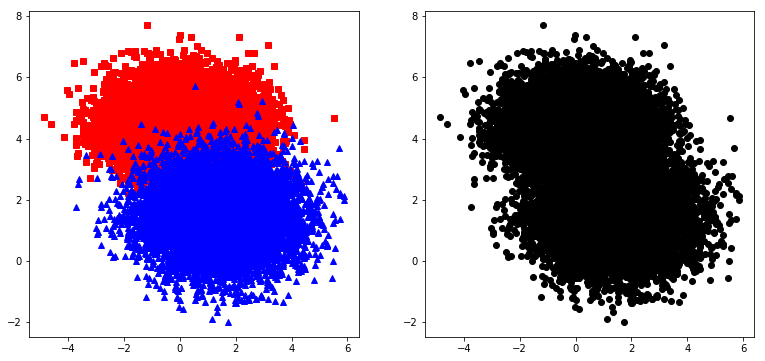

In [8]:
data1_true,data2_true,data = generate_data(10000,mu1_true,mu2_true,cov1_true,cov2_true)

pt.figure(1,figsize=(13,6))
pt.subplot(1,2,1)
pt.plot(data1_true[:,0],data1_true[:,1],'rs')
pt.plot(data2_true[:,0],data2_true[:,1],'b^')
pt.subplot(1,2,2)
pt.plot(data[:,0],data[:,1],'ko')
pt.show()

prob1_true = multivariate_normal.pdf(data,mean=mu1_true,cov=cov1_true)
prob2_true = multivariate_normal.pdf(data,mean=mu2_true,cov=cov2_true)
prob_true = 0.5*prob1_true+0.5*prob2_true
lnprob_true = np.sum(np.log(prob_true))

x_plot = np.arange(-6,10,0.5)
y_plot = np.arange(-6,10,0.5)

xx_plot, yy_plot = np.meshgrid(x_plot,y_plot)
xy_plot = np.stack((xx_plot,yy_plot),axis=-1)

lnprob1_true_plot = multivariate_normal.logpdf(xy_plot,mean=mu1_true,cov=cov1_true)
lnprob2_true_plot = multivariate_normal.logpdf(xy_plot,mean=mu2_true,cov=cov2_true)

We use the same random initialization as before to check the performance.

We find that the results are similar, but the parameter estimates are better than before. This is likely due to the increase of data points.

difference between mu1 and mu2:  [-0.02190065  0.0065388 ] [ 0.03336357 -0.04135378]
difference between cov1:  [-0.01900267  0.00922203] [ 0.00922203 -0.05253878]
difference between cov2:  [0.00249265 0.05268237] [ 0.05268237 -0.12595213]


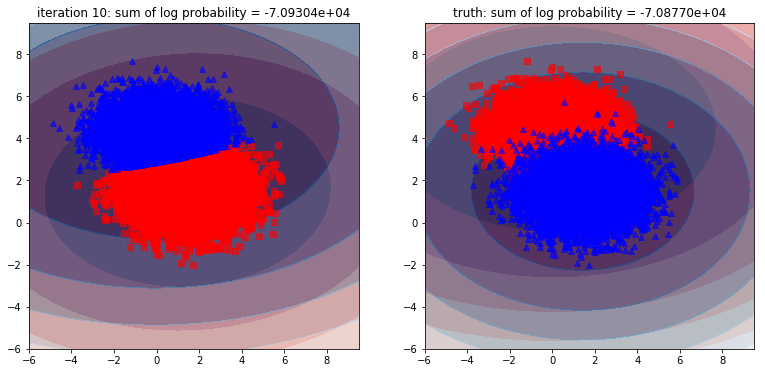

In [9]:
npr.seed(84)

mu1_new = npr.rand(2)*5
mu2_new = npr.rand(2)*5

var1_new = npr.rand(2)*2
var2_new = npr.rand(2)*2

corr1_new = np.array([[1,0],[0,1]])
corr2_new = np.array([[1,0],[0,1]])
corr1_new[0,1] = corr1_new[1,0] = 2*np.random.rand(1)-1
corr2_new[0,1] = corr2_new[1,0] = 2*np.random.rand(1)-1

cov1_new = corr1_new*np.sqrt(np.outer(var1_new,var1_new))
cov2_new = corr2_new*np.sqrt(np.outer(var2_new,var2_new))

n_iteration,condition_data1,mu1_new,mu2_new,cov1_new,cov2_new,lnprob = expectation_maximization(mu1_new,mu2_new,cov1_new,cov2_new)

# the order reverses so we take the differences between parameter(i)_new and parameter(j)_true
print('difference between mu1 and mu2: ',mu2_new-mu1_true,mu1_new-mu2_true)
print('difference between cov1: ',cov2_new[:,0]-cov1_true[:,0],cov2_new[:,1]-cov1_true[:,1])
print('difference between cov2: ',cov1_new[:,0]-cov2_true[:,0],cov1_new[:,1]-cov2_true[:,1])

For the bad initialization, the local maximum problem persists... But at least we can somewhat diagonose the problem using the total probability...

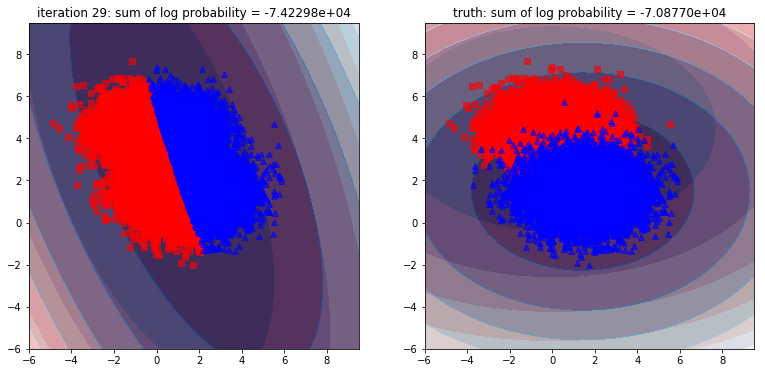

In [10]:
mu1_new = np.array([-2,2])
mu2_new = np.array([4,4])

var1_new = np.array([1,1])
var2_new = np.array([1,1])

corr1_new = np.array([[1,0],[0,1]])
corr2_new = np.array([[1,0],[0,1]])

cov1_new = corr1_new*np.sqrt(np.outer(var1_new,var1_new))
cov2_new = corr2_new*np.sqrt(np.outer(var2_new,var2_new))

n_iteration,condition_data1,mu1_new,mu2_new,cov1_new,cov2_new,lnprob = expectation_maximization(mu1_new,mu2_new,cov1_new,cov2_new)